In [31]:
%load_ext autoreload
%autoreload 2
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from itertools import zip_longest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam, LBFGS

from simdata import  fdd, pdeinp, icinp, bcinp,HT_sim ,scaler, invscaler
from loss_func import loss_fn_data,pde_loss,ic_loss,boundary_loss
from train_testloop import training_loop




Using device: cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation Data Generation for 1D Heat Transfer

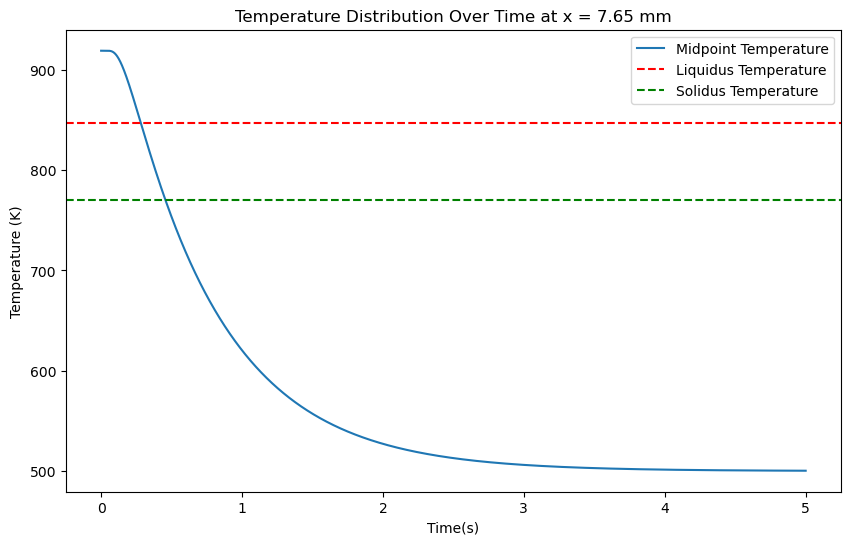

0.0003061224489795918
0.0012711033647622566


In [32]:
# The simulation data is generated using the datagen function in simdata.py
# the data solves 1D heat equation with dirichlet boundary conditions

length = 15e-3
time_end = 5.0
numpoints = 50
temp_init = 919.0
t_surr = 500.0

heat_data = HT_sim(length, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
tempfield = heat_data.datagen()

heat_data.plot_temp(25)
dt = heat_data.dt
print(heat_data.dx)
print(dt)




## Data Preparation for PINN training

In [33]:

# Temperature dataset
temp_data = tempfield.flatten()

def temp_scaler(temp_data, temp_init, t_surr):
    temp_data = (temp_data - t_surr) / (temp_init - t_surr)
    return temp_data

# temp_data = scaler(temp_data,400.0,919.0)

temp_data_s = temp_scaler(temp_data, temp_init, t_surr)





### Input Data preparation

In [34]:

# input dataset- fdd
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1] 

pde_pts= 20000
ic_pts = 10000
bc_pts = 10000

x_c = 1/length
t_c = (alpha/(length**2))
temp_c = 919.0

inp_data = fdd(15e-3, 40, numpoints, num_steps)


def scale2(x,x_c,t_c):
    x[:,0] = x[:,0] * x_c
    x[:,1] = x[:,1] * t_c
    return x

inp_data2 = scale2(inp_data,x_c,t_c)

# input dataset-pde residual
# The pde inputs are generated using the pdeinp function in simdata.py
pde_data = pdeinp(0.01,15e-3,0,time_end,pde_pts,"Hammersley",scl=1) 

pde_data2 = scale2(pde_data,x_c,t_c)

# input dataset - ic residual
ic_data = icinp(15e-3,ic_pts,scl="False")
ic_data2 = scale2(ic_data,x_c,t_c)
# input dataset - boundary residual
bc_ldata = bcinp(15e-3,40,bc_pts,dt,scl="False")[0]
bc_rdata = bcinp(15e-3,40,bc_pts,dt,scl="False")[1]

bc_ldata2 = scale2(bc_ldata,x_c,t_c)
bc_rdata2 = scale2(bc_rdata,x_c,t_c)


[0.         0.00030612 0.00061224 ... 0.01438776 0.01469388 0.015     ]
The number of points in the PDE input is 20000
The number of points in the initial condition is 10000
The number of points in the left boundary condition is 10000
The number of points in the right boundary condition is 10000
The number of points in the left boundary condition is 10000
The number of points in the right boundary condition is 10000


### GPU prep

In [35]:
# check for gpu
if torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

print('Using device:', device)

Using device: cuda
Using device: cuda


### Tensor inputs

In [36]:
input_t = torch.tensor(inp_data2).float().to(device)
inp_pdet = torch.tensor(pde_data2).float().to(device)
inp_ict = torch.tensor(ic_data2).float().to(device)
inp_bclt = torch.tensor(bc_ldata2).float().to(device)
inp_bclr = torch.tensor(bc_rdata2).float().to(device)



temp_t = torch.tensor(temp_data_s).float().to(device)
temp_t = temp_t.view(-1,1)

temp_init_s= temp_scaler(919.0, temp_init, t_surr)
# temp_init = scaler(temp_init,500.0,919.0)

temp_init_t = torch.tensor(temp_init_s).float().to(device)
T_L = (574.4 +273.0)                   #  K -Liquidus Temperature (615 c) AL 380
T_L_s = scaler(T_L,temp_init, t_surr)                     #  K -Liquidus Temperature (615 c) AL 380
# T_L = scaler(T_L,500.0,919.0)
T_S = (497.3 +273.0)                   #  K -Solidus Temperature (615 c) AL 380
T_S_s = scaler(T_S,temp_init, t_surr)                     #  K -Solidus Temperature (615 c) AL 380
# T_S = scaler(T_S,500.0,919.0)                     #  K -Solidus Temperature (615 c) AL 380
t_surr_s = temp_scaler(t_surr, temp_init, t_surr)
# t_surr = scaler(t_surr,500.0,919.0)
T_lt = torch.tensor(T_L_s).float().to(device)    # Liquidus Temperature tensor
T_st = torch.tensor(T_S_s).float().to(device)    # Solidus Temperature tensor
t_surrt = torch.tensor(t_surr_s).float().to(device)   # Surrounding Temperature tensor

temp_var = {"T_st":T_st,"T_lt":T_lt,"t_surrt":t_surrt,"temp_init_t":temp_init_t}


### Dataset Preparation for pytorch

In [37]:
train_inputs,test_inputs =train_test_split(input_t,test_size=0.2,random_state=42) # input data split
print(train_inputs.shape)
tr_inp_pde,ts_inp_pde = train_test_split( inp_pdet,test_size=0.2,random_state=42) # input pde data split
print(tr_inp_pde.shape)
tr_inp_ic,ts_inp_ic = train_test_split( inp_ict,test_size=0.2,random_state=42) # input ic data split
print(tr_inp_ic.shape)

tr_inp_bcl,ts_inp_bcl = train_test_split( inp_bclt,test_size=0.2,random_state=42) # input bc left data split
tr_inp_bcr,ts_inp_bcr = train_test_split( inp_bclr,test_size=0.2,random_state=42) # input bc right data split
# nn
# 

train_temp,test_temp = train_test_split(temp_t,test_size=0.2,random_state=42) # output data split



torch.Size([157400, 2])
torch.Size([16000, 2])
torch.Size([8000, 2])


In [38]:
class Data_Tensor_Dataset(TensorDataset):#dataset class for tsimulation data
    def __init__(self,inputs,outputs,transform=None, target_transform =None):   
        self.inputs = inputs
        self.outputs = outputs

    def __getitem__(self, index):
        return self.inputs[index],self.outputs[index]
    
    def __len__(self):
        return len(self.inputs)

class ResDataset(TensorDataset): #dataset class for pde residuals and bcs,ics
    def __init__(self, inputs,transform=None, target_transform =None):
        self.inputs = inputs
        

    def __getitem__(self, index):
        return self.inputs[index]
    
    def __len__(self):
        return len(self.inputs)

### Dataset Preparation

In [39]:
inp_dataset = Data_Tensor_Dataset(train_inputs,train_temp)
inp_dataset_test = Data_Tensor_Dataset(test_inputs,test_temp)

inp_pde_dataset = ResDataset(tr_inp_pde) # pde residual dataset for training
inp_pde_dataset_test = ResDataset(ts_inp_pde) # pde residual dataset for testing

inp_ic_dataset = ResDataset(tr_inp_ic) # ic residual dataset for training
inp_ic_dataset_test = ResDataset(ts_inp_ic) # ic residual dataset for testing

inp_bcl_dataset = ResDataset(tr_inp_bcl) # bc left residual dataset for training
inp_bcl_dataset_test = ResDataset(ts_inp_bcl) # bc left residual dataset for testing

inp_bcr_dataset = ResDataset(tr_inp_bcr) # bc right residual dataset for training
inp_bcr_dataset_test = ResDataset(ts_inp_bcr)   # bc right residual dataset for testing

In [40]:
print(len(inp_ic_dataset))

8000


### Dataloader Preparation

In [41]:
rand_smpl = RandomSampler(inp_dataset, replacement=True, num_samples=1000)  # random sampler for training/simulation data
rand_smpl_pde = RandomSampler(inp_pde_dataset, replacement=True, num_samples=len(inp_pde_dataset)) # random sampler for pde residuals-training
rand_smpl_ic = RandomSampler(inp_ic_dataset, replacement=True, num_samples=len(inp_ic_dataset))  # random sampler for ic residuals-training
rand_smpl_bcl = RandomSampler(inp_bcl_dataset, replacement=True, num_samples=len(inp_bcl_dataset)) # random sampler for bc left residuals-training
rand_smpl_bcr = RandomSampler(inp_bcr_dataset, replacement=True, num_samples=len(inp_bcr_dataset)) # random sampler for bc right residuals-training

rand_smpl_test = RandomSampler(inp_dataset_test, replacement=True, num_samples=1000)  # random sampler for testing/simulation data
rand_smpl_pde_test = RandomSampler(inp_pde_dataset_test,replacement=True, num_samples=len(inp_pde_dataset_test))  # random sampler for pde residuals
rand_smpl_ic_test = RandomSampler(inp_ic_dataset_test,replacement=True, num_samples= len(inp_ic_dataset_test))  # random sampler for ic residuals
rand_smpl_bcl_test = RandomSampler(inp_bcl_dataset_test,replacement=True,num_samples=len(inp_bcl_dataset_test)) # random sampler for bc left residuals
rand_smpl_bcr_test = RandomSampler(inp_bcr_dataset_test,replacement=True,num_samples=len(inp_bcr_dataset_test)) # random sampler for bc right residuals

train_loader = DataLoader(inp_dataset, batch_size=256, sampler=rand_smpl) # training data loader
pde_loader = DataLoader(inp_pde_dataset, batch_size=256, sampler=rand_smpl_pde) # pde residual data loader training
ic_loader = DataLoader(inp_ic_dataset, batch_size=256, sampler=rand_smpl_ic) # ic residual data loader training
bcl_loader = DataLoader(inp_bcl_dataset, batch_size=256, sampler=rand_smpl_bcl) # bc left residual data loader training
bcr_loader = DataLoader(inp_bcr_dataset, batch_size=256, sampler=rand_smpl_bcr) # bc right residual data loader training


test_loader = DataLoader(inp_dataset_test, batch_size=256, sampler=rand_smpl_test) # testing data loader
pde_loader_test = DataLoader(inp_pde_dataset_test, batch_size=256, sampler=rand_smpl_pde_test)
ic_loader_test = DataLoader(inp_ic_dataset_test, batch_size=256, sampler=rand_smpl_ic_test)
bcl_loader_test = DataLoader(inp_bcl_dataset_test, batch_size=256, sampler=rand_smpl_bcl_test)
bcr_loader_test = DataLoader(inp_bcr_dataset_test, batch_size=256, sampler=rand_smpl_bcr_test)




## NN Architecture Definition

In [42]:
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers):  # Constructor initializes the network
        super(PINN, self).__init__()  # Call the parent class (nn.Module) constructor
        layers = []  # Initialize an empty list to store the network layers

        # Input layer: Takes input features and maps them to the hidden layer size
        layers.append(nn.Linear(input_size, hidden_size))  # Add the first linear layer
        layers.append(nn.Tanh())  # Apply the activation function (Tanh)

        # Hidden layers: Create a series of hidden layers with activation functions
        for _ in range(hidden_layers):  # Loop for creating multiple hidden layers
            layers.append(nn.Linear(hidden_size, hidden_size))  # Add a hidden linear layer
            layers.append(nn.Tanh())  # Add an activation function (Tanh)

        # Output layer: Maps the final hidden layer outputs to the desired output size
        layers.append(nn.Linear(hidden_size, output_size))  # Add the final linear layer
        self.base = nn.Sequential(*layers)  # Create a sequential container with all layers
        self._init_weights()  # Initialize the network weights  

    def _init_weights(self):
        for layer in self.base:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x, t):  # Define the forward pass of the network
        input_features = torch.cat([x, t], dim=1)  # Concatenate input tensors along dimension 1
        m = self.base(input_features)  # Pass the concatenated input through the network
        return m  # Return the network output
    
    


In [43]:
input_size = 2
hidden_size = 20
output_size=1

learning_rate = 0.005
hidden_layers = 4

epochs_1 = 5000
epochs_2 = 10

model = PINN(input_size, hidden_size, output_size,hidden_layers).to(device)
optimizer_1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_2 = torch.optim.LBFGS(model.parameters(), lr=learning_rate)


In [44]:
# print(model)

### Loss Function 

In [45]:
torch.autograd.set_detect_anomaly(True)

#train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs_1, model, loss_fn_data, \
                #   optimizer_1,train_loader,pde_loader, ic_loader,\
                #   bcl_loader,bcr_loader,\
                #   test_loader,pde_loader_test,ic_loader_test,\
                #   bcl_loader_test,bcr_loader_test,\
                #   temp_var)  # Train the model 

loss_train,loss_test, best_model = training_loop(epochs_1, model, loss_fn_data, \
                  optimizer_1,train_loader,pde_loader, ic_loader,\
                  bcl_loader,bcr_loader,\
                  test_loader,pde_loader_test,ic_loader_test,\
                  bcl_loader_test,bcr_loader_test,\
                  temp_var)

# train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs_2, model, loss_fn_data, \
#                   optimizer_2,train_loader,pde_loader, ic_loader,\
#                   bcl_loader,bcr_loader,\
#                   test_loader,pde_loader_test,ic_loader_test,\
#                   bcl_loader_test,bcr_loader_test,\
#                   temp_var) 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model



 
----------------------------------------------------------------------------------------------------
| Epoch 1,            | Training-Loss 4.6111e+00,| Test-Loss 2.1068e+00   |
----------------------------------------------------------------------------------------------------
| Data-loss 8.3426e-02,| pde-loss 3.5144e-01,| initc-loss 3.4651e-02,|bc_loss 1.7613e-01|
----------------------------------------------------------------------------------------------------
| Data-loss-test 2.2064e-01,| pde-loss-test 1.1250e-01,| initc-loss-test 2.2174e-02,|bc_loss-test 1.8826e-01|
----------------------------------------------------------------------------------------------------
 
 
----------------------------------------------------------------------------------------------------
| Epoch 11,            | Training-Loss 5.6124e-01,| Test-Loss 5.3769e-01   |
----------------------------------------------------------------------------------------------------
| Data-loss 2.0162e-02,| pde-loss 5

In [46]:
#  Save the loss dictionary in pkl

# with open('losses.pkl', 'wb') as f:
#     pickle.dump(loss_train, f)
#     pickle.dump(loss_test, f)
#     # pickle.dump(pde_losses, f)
#     # pickle.dump(ic_losses, f)
#     # pickle.dump(bc_losses, f)
#     # pickle.dump(data_losses, f)

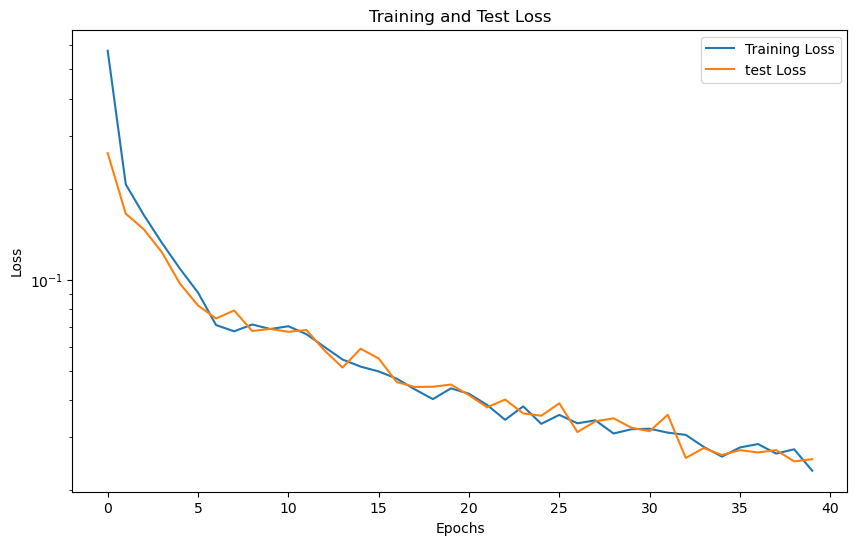

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(loss_train["train-loss"], label='Training Loss')
plt.plot(loss_test["test-loss"], label='test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

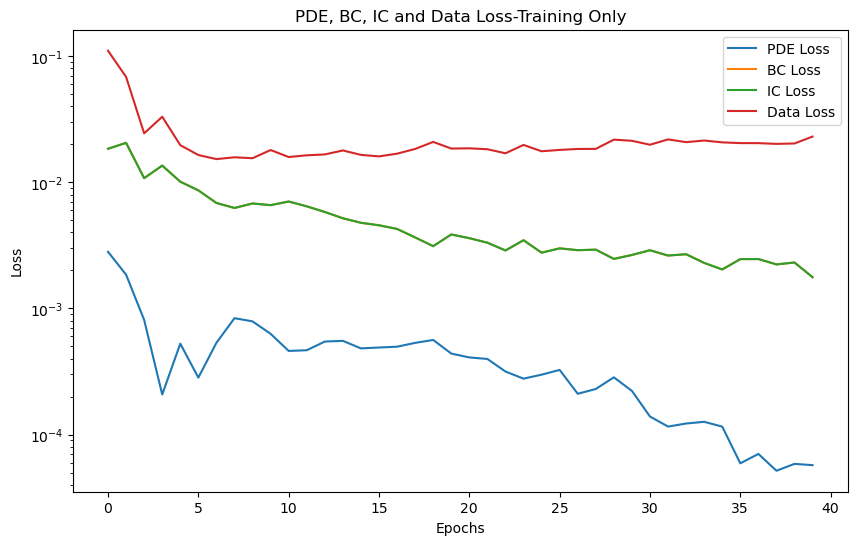

In [48]:
pde_losses = np.array(loss_train["pde-loss"])
bc_losses = np.array(loss_train["bc-loss"])
ic_losses = np.array(loss_train["bc-loss"])

data_losses = np.array(loss_train["data-loss"])

plt.figure(figsize=(10, 6))
plt.plot(pde_losses, label='PDE Loss')
plt.plot(bc_losses, label='BC Loss')
plt.plot(ic_losses, label='IC Loss')
plt.plot(data_losses, label='Data Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('PDE, BC, IC and Data Loss-Training Only')
plt.legend()
plt.show()



In [49]:
inp_data = input_t
# inp_data = torch.tensor(input_t).float().to(device) # Convert the inputs to a tensor

# load model saved
model = best_model
temp_nn = model(inp_data[:,0].unsqueeze(1), inp_data[:,1].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model





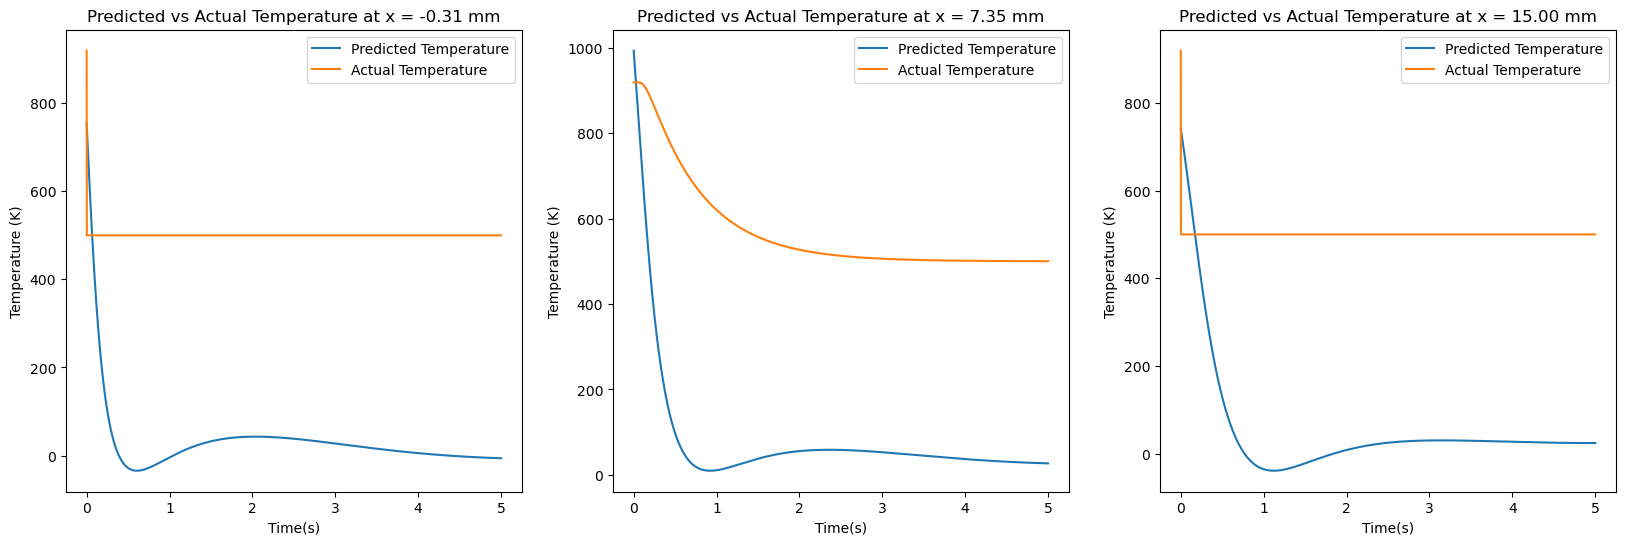

In [50]:
dx = heat_data.dx
# temp_nn = invscaler(temp_nn,500.0,919.0) # Inverse transform the predictions
temp_nn = temp_nn * temp_c
temp_nn = temp_nn.reshape(num_steps, numpoints) # Reshape the predictions to a 2D array
time_ss= np.linspace(0, time_end, num_steps )
left , idx, right = 0, 25, 50

fig = plt.figure(figsize=(20, 6))
ax1,ax2,ax3 = fig.subplots(1,3)
ax1.plot(time_ss, temp_nn[:,left], label='Predicted Temperature')
ax1.plot(time_ss, tempfield[:,left], label='Actual Temperature') 
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Temperature (K)')
ax1.set_title(f'Predicted vs Actual Temperature at x = {(left-1)*dx*1000:.2f} mm')
ax1.legend()

ax2.plot(time_ss, temp_nn[:,idx-1], label='Predicted Temperature')
ax2.plot(time_ss, tempfield[:,idx-1], label='Actual Temperature')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title(f'Predicted vs Actual Temperature at x = {(idx-1)*dx*1000:.2f} mm')
ax2.legend()

ax3.plot(time_ss, temp_nn[:,right-1], label='Predicted Temperature')
ax3.plot(time_ss, tempfield[:,right-1], label='Actual Temperature')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Temperature (K)')
ax3.set_title(f'Predicted vs Actual Temperature at x = {(right-1)*dx*1000:.2f} mm')
ax3.legend()
plt.show()



Text(0.5, 1.0, 'Predicted Temperature Distribution along initial condition')

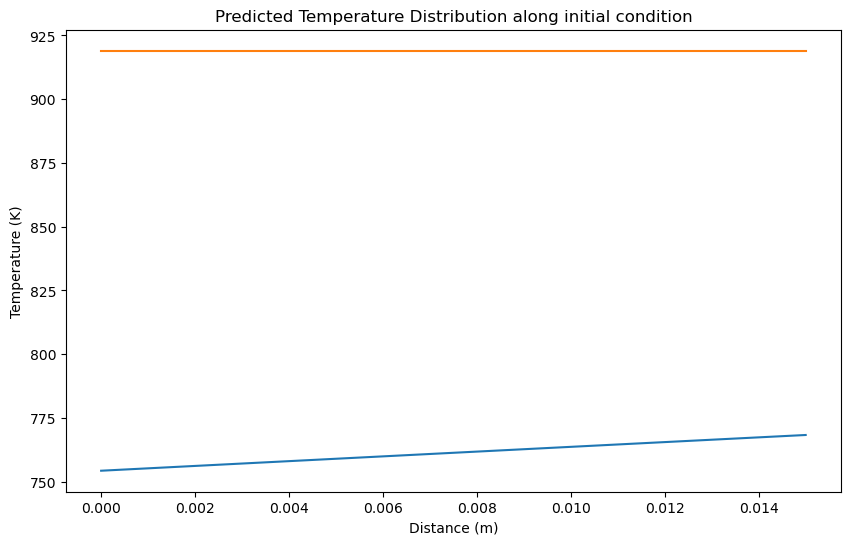

In [51]:
x = np.linspace(0, 15e-3, 100)
t = np.zeros_like(x)

x = torch.tensor(x).float().to(device)
t = torch.tensor(t).float().to(device)
temp_pred = model(x.unsqueeze(1), t.unsqueeze(1)).cpu().detach().numpy()
temp_pred = temp_pred * 919.0
Act_temp = (torch.ones_like(x) * 919.0).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x.cpu().detach().numpy(), temp_pred, label='Predicted Temperature')
plt.plot(x.cpu().detach().numpy(), Act_temp, label='Actual Temperature')
plt.xlabel('Distance (m)')
plt.ylabel('Temperature (K)')
plt.title('Predicted Temperature Distribution along initial condition')
#end


(3935, 50)
(3935, 50)


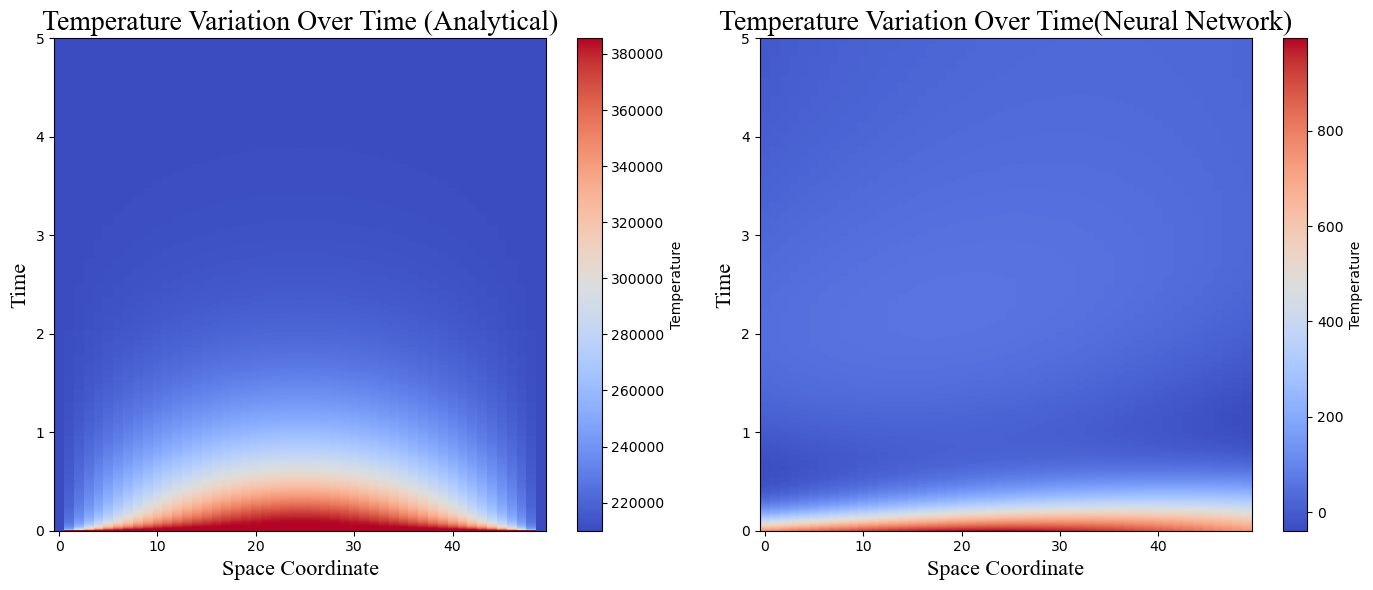

In [52]:
#input data
def temp_invscaler(temp_data, temp_init, t_surr):
    temp_data = temp_data * (temp_init - t_surr) + t_surr
    return temp_data

Act_temp = temp_invscaler(temp_data, temp_init, t_surr)
Act_temp = Act_temp.reshape(num_steps, numpoints)
print(Act_temp.shape)

input_pred = input_t
temp_nn = model(input_pred[:,0].unsqueeze(1), input_pred[:,1].unsqueeze(1)).cpu().detach().numpy()
temp_nn = temp_nn * 919.0
temp_nn = temp_nn.reshape(num_steps, numpoints)

print(temp_nn.shape)

space_coord, time_coord = np.meshgrid(np.arange(Act_temp.shape[1]), np.arange(Act_temp.shape[0]))
time_coord = time_coord * dt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))



# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, Act_temp, cmap='coolwarm')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time (Analytical)',fontname='Times New Roman', fontsize=20)
fig.colorbar(im1, ax=ax1, label='Temperature')

im2 = ax2.pcolormesh(space_coord, time_coord, temp_nn, cmap='coolwarm')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Temperature Variation Over Time(Neural Network)',fontname='Times New Roman', fontsize=20)
fig.colorbar(im2, ax=ax2, label='Temperature')

plt.tight_layout()

plt.show()

